<a href="https://colab.research.google.com/github/debsa2000/EED380_AppliedDeepLearning/blob/main/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
import itertools

from tensorflow import keras
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.initializers import RandomNormal

import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior() 

sns.set(style='white', context='notebook', palette='deep')

import warnings
warnings.filterwarnings("ignore")

In [9]:
# Load the data
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

# Data Visualization

In [10]:
train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
test

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,183,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51,252,20,0,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
train.isnull().any().describe()

count       785
unique        1
top       False
freq        785
dtype: object

In [13]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

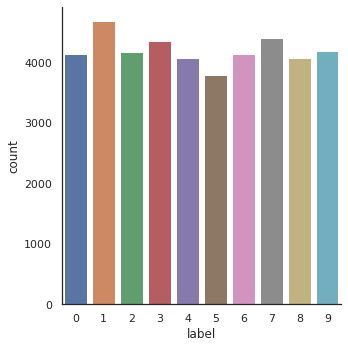

In [14]:
# label count bar graph
sns.catplot(x="label",kind="count", data=train)

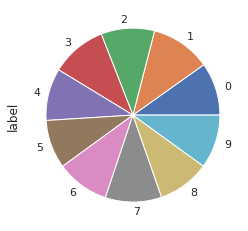

In [15]:
# pie chart for label distribution
train.groupby("label")["label"].count().plot(kind="pie")


In [16]:
Y_train = train["label"]
X_train = train.drop(["label"],axis = 1)
X_test = test

In [17]:
# getting indexes of first 10 occurences for each number

list_of_indexes = []

for i in range(10):
    for nr in range(10):
        ix = Y_train[Y_train==nr].index[i]
        list_of_indexes.append(ix)


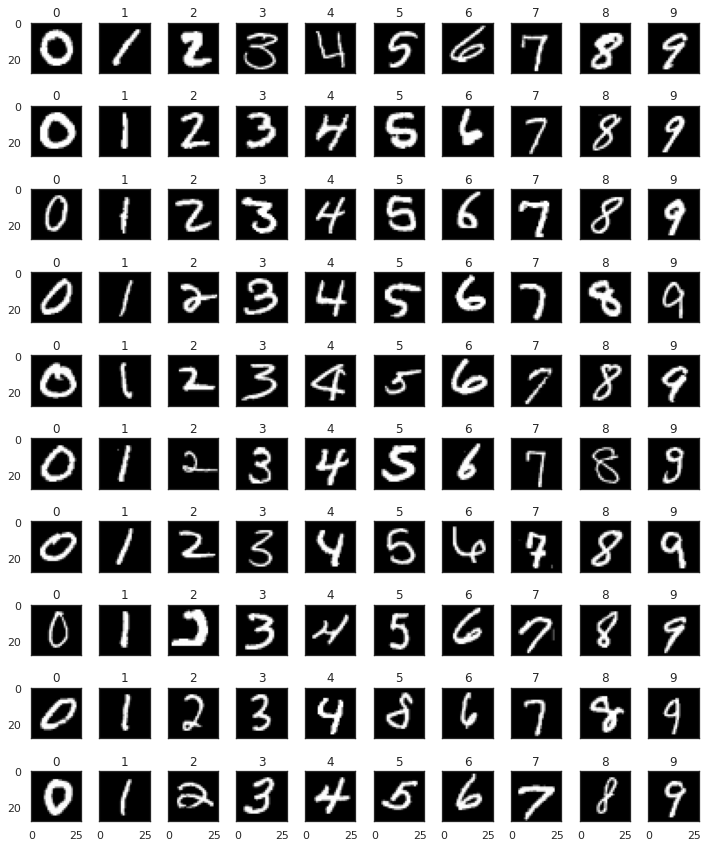

In [18]:
# plotting first 10 handwritten samples for each digit
fig, axs = plt.subplots(10, 10, sharex=True, sharey=True, figsize=(10,12))
axs = axs.flatten()

for n, i in enumerate(list_of_indexes):
    im = X_train.iloc[i]
    im = im.values.reshape(-1,28,28,1)
    axs[n].imshow(im[0,:,:,0], cmap=plt.get_cmap('gray'))
    axs[n].set_title(Y_train[i])

plt.tight_layout()  

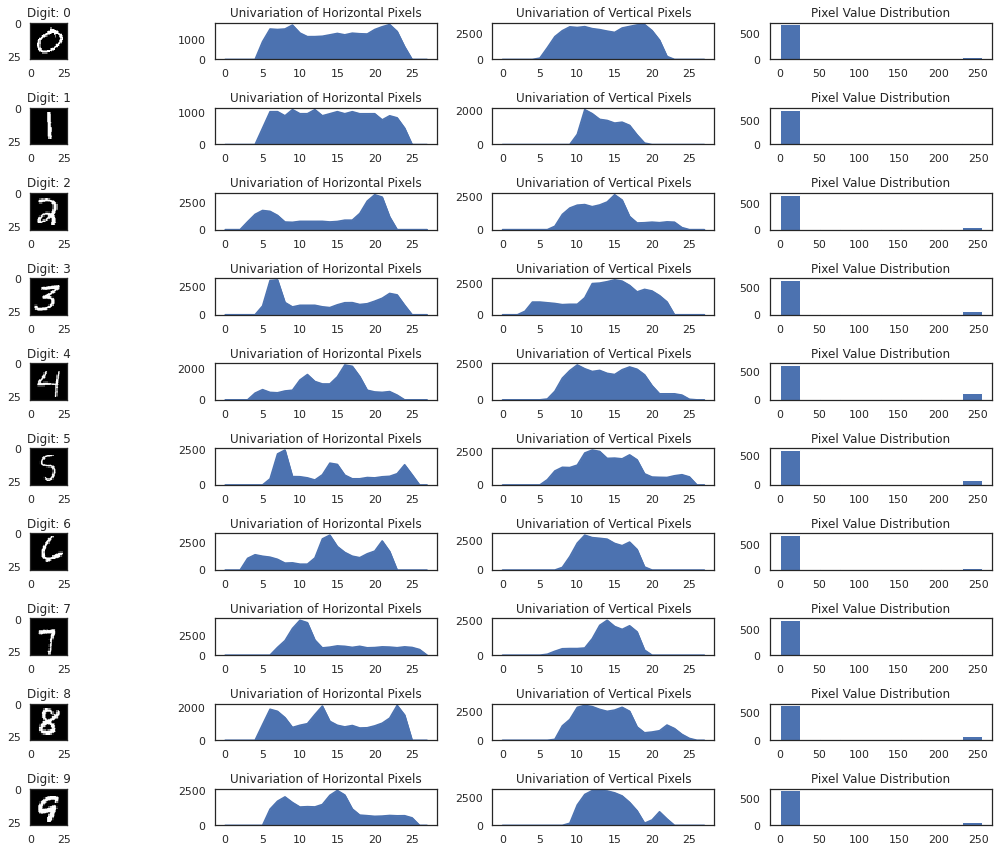

In [19]:
# plotting pixel value distribution

plt.figure(figsize=(15, 12))
j = 1
for i in range(10) :
    plt.subplot(10,4,j)
    j +=1
    plt.imshow(train[Y_train == i].sample(1).drop(labels = ["label"],axis = 1).values.reshape(28, 28), cmap='gray', interpolation='none')
    plt.title("Digit: {}".format(i))
    plt.subplot(10,4,j)
    j +=1
    pd.DataFrame(train[Y_train == i].sample(1).drop(labels = ["label"],axis = 1).values.reshape(28, 28)).sum(axis = 1).plot.area(title = 'Univariation of Horizontal Pixels')
    plt.subplot(10,4,j)
    j +=1
    pd.DataFrame(train[Y_train == i].sample(1).drop(labels = ["label"],axis = 1).values.reshape(28, 28)).sum(axis = 0).plot.area(title = 'Univariation of Vertical Pixels')
    plt.subplot(10,4,j)
    j +=1
    plt.hist(train[Y_train == i].sample(1).drop(labels = ["label"],axis = 1))
    plt.title("Pixel Value Distribution")
plt.tight_layout()

# Preprocessing

In [20]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)


In [21]:
X_train.shape, Y_train.shape

((37800, 784), (37800,))

In [22]:
X_val.shape, Y_val.shape

((4200, 784), (4200,))

In [23]:
X_test.shape

(28000, 784)

In [24]:
# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

In [25]:
# # Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
# X_train = X_train.values.reshape(-1,28,28,1)
# X_test = X_test.values.reshape(-1,28,28,1)
# X_val = X_val.values.reshape(-1,28,28,1)

# X_train.shape, X_val.shape, X_test.shape

In [28]:
# Label Encoding: One Hot Encoding (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])

Y_train = keras.utils.to_categorical(Y_train, num_classes = 10)
Y_val = keras.utils.to_categorical(Y_val, num_classes=10)

In [29]:
Y_train.shape, Y_val.shape

((37800, 10), (4200, 10))

# Modelling

## A Simple Neural Network

### Defining, Compiling and Fitting the Model

In [30]:
model_simple = Sequential()
model_simple.add(Dense(64, activation="sigmoid", input_shape=(784,)))
model_simple.add(Dense(10, activation="softmax"))

In [31]:
model_simple.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


In [32]:
model_simple.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.01), metrics=["accuracy"])

In [33]:
history_simple = model_simple.fit(x=X_train, y=Y_train, batch_size=128, epochs=50, verbose=0, validation_data=(X_val, Y_val))

### Evaluating the model

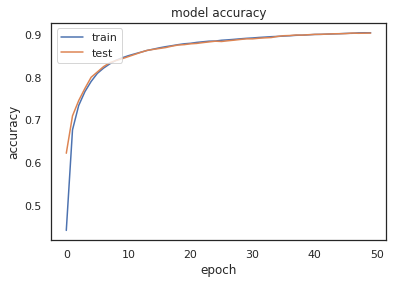

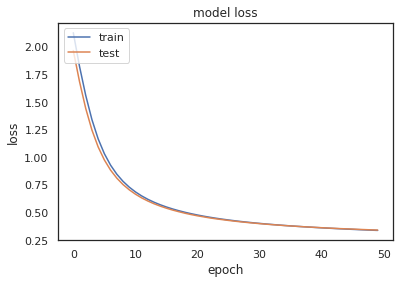

In [34]:
def plot_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
plot_history(history_simple)

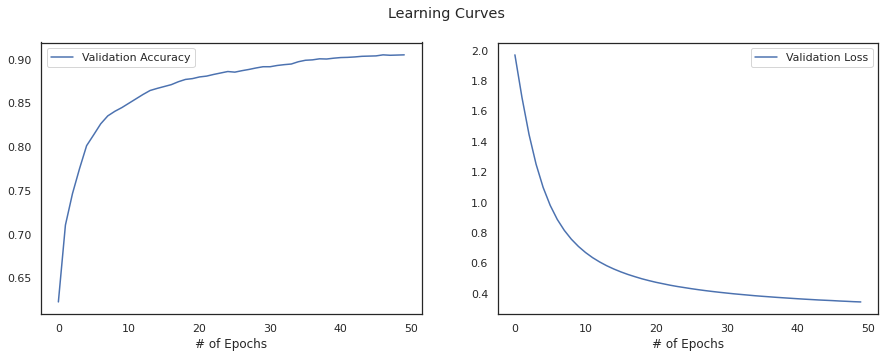

In [35]:
val_loss = history_simple.history["val_loss"]
val_accuracy = history_simple.history["val_acc"]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(x=range(0,len(val_accuracy)), y=val_accuracy, ax=ax[0], label="Validation Accuracy")
sns.lineplot(x=range(0,len(val_loss)), y=val_loss, ax=ax[1], label="Validation Loss")

ax[0].set_xlabel("# of Epochs")
ax[1].set_xlabel("# of Epochs")

plt.suptitle("Learning Curves")
plt.show()

In [36]:
#Print loss and accuracy
model_simple.evaluate(X_val, Y_val)

[0.3423165742556254, 0.9045238]

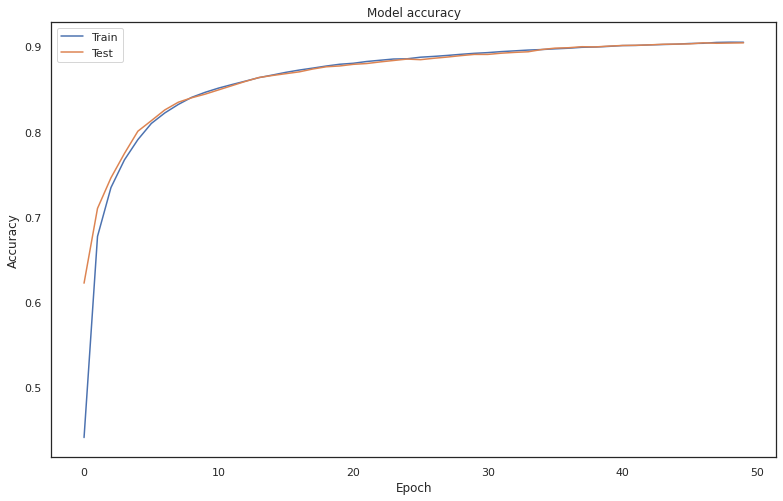

In [37]:
plt.subplots(figsize=(13, 8))
plt.plot(history_simple.history['acc'])
plt.plot(history_simple.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

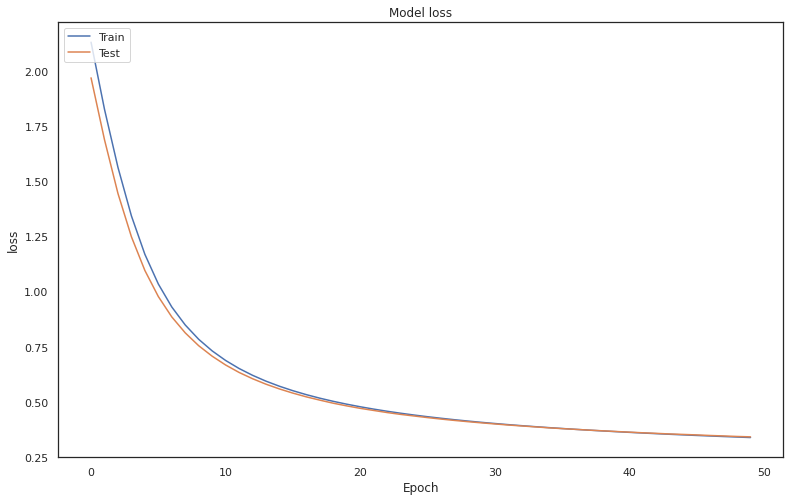

In [38]:
plt.subplots(figsize=(13, 8))
plt.plot(history_simple.history['loss'])
plt.plot(history_simple.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [39]:
#Prediction
p = model_simple.predict(X_val)
p = (p > 0.5)
print('ACCURACY OF SIMPLEST MODEL: %.3f%%' % (accuracy_score(Y_val, p)*100))
print('---------')
print(classification_report(Y_val, p))

ACCURACY OF SIMPLEST MODEL: 87.071%
---------
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       411
           1       0.96      0.96      0.96       485
           2       0.94      0.85      0.89       403
           3       0.92      0.86      0.89       418
           4       0.95      0.90      0.92       461
           5       0.93      0.75      0.83       372
           6       0.95      0.91      0.93       413
           7       0.94      0.84      0.89       446
           8       0.90      0.82      0.86       382
           9       0.88      0.83      0.86       409

   micro avg       0.93      0.87      0.90      4200
   macro avg       0.93      0.87      0.90      4200
weighted avg       0.93      0.87      0.90      4200
 samples avg       0.87      0.87      0.87      4200



### Saving the model

In [40]:
model_simple.save("simplest_model.hd5")
# model = keras.models.load_model("model.hd5")
# model.summary()

## Experimentation

In [41]:
# Helper Functions
class NeuralNetwork():
    def __init__(self, name, batch_size, epochs, learning_rate, verbose):
        self.name = name
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.verbose = verbose
        self.model = Sequential()
        
    def add_(self, layer):
        self.model.add(layer)

    def compile_and_fit(self):
        self.model.compile(loss="mean_squared_error", optimizer=SGD(lr=self.learning_rate), metrics=["accuracy"])
        self.history = self.model.fit(x=X_train,
                                      y=Y_train,
                                      batch_size=self.batch_size,
                                      epochs=self.epochs,
                                      verbose=self.verbose,
                                      validation_data=(X_val, Y_val))
        self.val_loss = self.history.history["val_loss"]
        self.val_accuracy = self.history.history["val_acc"]
    
    def plot_learning_curves(self):
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
        
        sns.lineplot(x=range(0,len(self.val_acc)), y=self.val_acc, ax=ax[0], label="Validation Accuracy")
        sns.lineplot(x=range(0,len(self.val_loss)), y=self.val_loss, ax=ax[1], label="Validation Loss")

        ax[0].set_xlabel("# of Epochs")
        ax[1].set_xlabel("# of Epochs")

        plt.suptitle("Learning Curves: {}".format(self.name))
        plt.show()

    def evaluate_(self):
        return self.model.evaluate(X_valid, y_valid)
    
    def save(self, filename):
        self.model.save("working/"+filename+".hd5")
        
    def summary_(self):
        return self.model.summary()

In [42]:
def compare_learning_curves(models):
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    
    for model in models:
        sns.lineplot(x=range(0,len(model.val_accuracy)), y=model.val_accuracy, ax=ax[0], label=model.name)
        sns.lineplot(x=range(0,len(model.val_loss)), y=model.val_loss, ax=ax[1], label=model.name)
    
    ax[0].set_xlabel("# of Epochs")
    ax[1].set_xlabel("# of Epochs")

    ax[0].set_title("Validation Accuracy")
    ax[1].set_title("Validation Loss")

    plt.suptitle("Learning Curves")
    plt.show()

### Batch Size

In [43]:
batch_sizes = [8, 16, 32, 64, 128, 256]
n_epochs = 50

In [44]:
accuracy = pd.DataFrame(columns=batch_sizes, index=range(n_epochs))
loss = pd.DataFrame(columns=batch_sizes, index=range(n_epochs))
accuracy["Epoch"] = range(n_epochs)
loss["Epoch"] = range(n_epochs)

In [45]:
for batch_size in batch_sizes:
    model = Sequential()
    model.add(Dense(64, activation="sigmoid", input_shape=(784,)))
    model.add(Dense(10, activation="softmax"))
    model.compile(loss="mean_squared_error", optimizer=SGD(lr=0.01), metrics=["accuracy"])
    
    hist = model.fit(x=X_train,
              y=Y_train,
              batch_size=batch_size,
              epochs=n_epochs,
              verbose=0,
              validation_data=(X_val, Y_val))
    
    accuracy[batch_size] = hist.history["val_acc"]
    loss[batch_size] = hist.history["val_loss"]

In [46]:
accuracy_melt = accuracy.melt(value_name="Accuracy", var_name="Batch Size", id_vars=["Epoch"])
loss_melt = loss.melt(value_name="Loss", var_name="Batch Size", id_vars=["Epoch"])

accuracy_melt["Batch Size"] = accuracy_melt["Batch Size"].astype(object)
loss_melt["Batch Size"] = loss_melt["Batch Size"].astype(object)

In [47]:
accuracy_melt = accuracy.melt(value_name="Accuracy", var_name="Batch Size", id_vars=["Epoch"])
loss_melt = loss.melt(value_name="Loss", var_name="Batch Size", id_vars=["Epoch"])

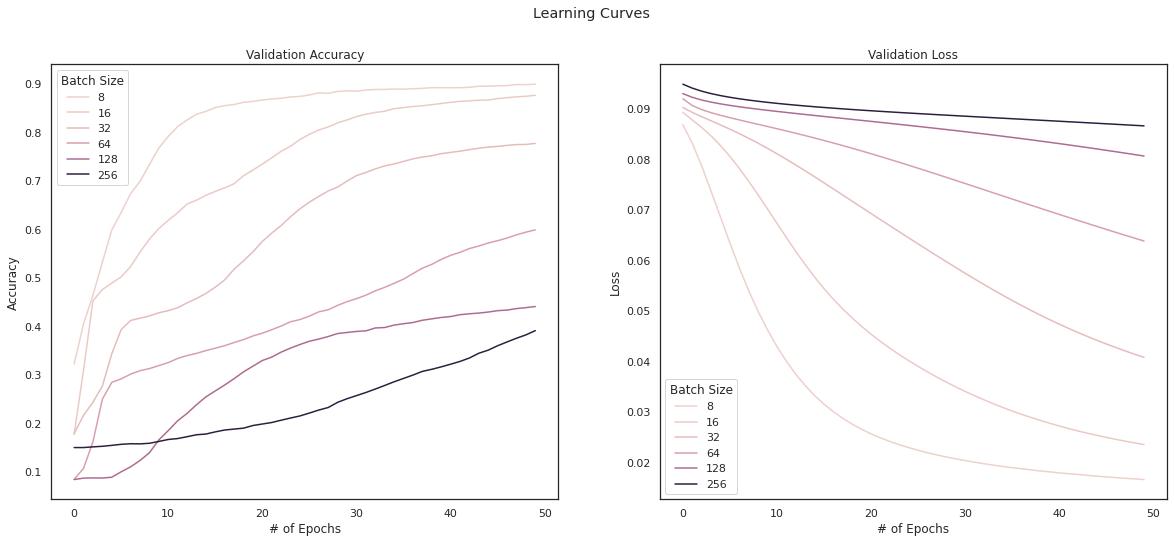

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.lineplot(x="Epoch", y="Accuracy", hue="Batch Size", data=accuracy_melt, ax=ax[0], legend="full")
sns.lineplot(x="Epoch", y="Loss", hue="Batch Size", data=loss_melt, ax=ax[1], legend="full")

ax[0].set_title("Validation Accuracy")
ax[1].set_title("Validation Loss")

ax[0].set_xlabel("# of Epochs")
ax[1].set_xlabel("# of Epochs")

plt.suptitle("Learning Curves")
plt.show()

### Learning Rate

In [49]:
n_epochs = 100
batch_size = 128
verbose = 0

In [50]:
learning_rate = 100
nn_lr_100 = NeuralNetwork("LR = {}".format(learning_rate), batch_size, n_epochs, learning_rate, verbose)
nn_lr_100.add_(Dense(64, activation="sigmoid", input_shape=(784,)))
nn_lr_100.add_(Dense(10, activation="softmax"))

learning_rate = 1000
nn_lr_1000 = NeuralNetwork("LR = {}".format(learning_rate), batch_size, n_epochs, learning_rate, verbose)
nn_lr_1000.add_(Dense(64, activation="sigmoid", input_shape=(784,)))
nn_lr_1000.add_(Dense(10, activation="softmax"))

learning_rate = 10
nn_lr_10 = NeuralNetwork("LR = {}".format(learning_rate), batch_size, n_epochs, learning_rate, verbose)
nn_lr_10.add_(Dense(64, activation="sigmoid", input_shape=(784,)))
nn_lr_10.add_(Dense(10, activation="softmax"))

learning_rate = 1
nn_lr_1 = NeuralNetwork("LR = {}".format(learning_rate), batch_size, n_epochs, learning_rate, verbose)
nn_lr_1.add_(Dense(64, activation="sigmoid", input_shape=(784,)))
nn_lr_1.add_(Dense(10, activation="softmax"))

learning_rate = 0.1
nn_lr_p1 = NeuralNetwork("LR = {}".format(learning_rate), batch_size, n_epochs, learning_rate, verbose)
nn_lr_p1.add_(Dense(64, activation="sigmoid", input_shape=(784,)))
nn_lr_p1.add_(Dense(10, activation="softmax"))

learning_rate = 0.01 # default
nn_lr_p01 = NeuralNetwork("LR = {}".format(learning_rate), batch_size, n_epochs, learning_rate, verbose)
nn_lr_p01.add_(Dense(64, activation="sigmoid", input_shape=(784,)))
nn_lr_p01.add_(Dense(10, activation="softmax"))

learning_rate = 0.001
nn_lr_p001 = NeuralNetwork("LR = {}".format(learning_rate), batch_size, n_epochs, learning_rate, verbose)
nn_lr_p001.add_(Dense(64, activation="sigmoid", input_shape=(784,)))
nn_lr_p001.add_(Dense(10, activation="softmax"))

nn_lr_100.compile_and_fit()
nn_lr_1000.compile_and_fit()
nn_lr_10.compile_and_fit()
nn_lr_1.compile_and_fit()
nn_lr_p1.compile_and_fit()
nn_lr_p01.compile_and_fit()
nn_lr_p001.compile_and_fit()

KeyboardInterrupt: ignored

In [ ]:
learning_rate = 0.1
nn_lr_p1 = NeuralNetwork("LR = {}".format(learning_rate), batch_size, n_epochs, learning_rate, verbose)
nn_lr_p1.add_(Dense(64, activation="sigmoid", input_shape=(784,)))
nn_lr_p1.add_(Dense(10, activation="softmax"))
nn_lr_p1.compile_and_fit()

In [ ]:
compare_learning_curves([nn_lr_1000, nn_lr_100, nn_lr_10, nn_lr_1, nn_lr_p1, nn_lr_p01, nn_lr_p001])

### Activation Functions

In [ ]:
n_epochs = 100
batch_size = 128
learning_rate = 0.01
verbose = 0

In [ ]:
nn_sigmoid = NeuralNetwork("Sigmoid", batch_size, n_epochs, learning_rate, verbose)
nn_sigmoid.add_(Dense(64, activation="sigmoid", input_shape=(784,)))
nn_sigmoid.add_(Dense(10, activation="softmax"))
nn_sigmoid.compile_and_fit()

nn_tanh = NeuralNetwork("Tanh", batch_size, n_epochs, learning_rate, verbose)
nn_tanh.add_(Dense(64, activation="tanh", input_shape=(784,)))
nn_tanh.add_(Dense(10, activation="softmax"))
nn_tanh.compile_and_fit()

nn_relu = NeuralNetwork("ReLU", batch_size, n_epochs, learning_rate, verbose)
nn_relu.add_(Dense(64, activation="relu", input_shape=(784,)))
nn_relu.add_(Dense(10, activation="softmax"))
nn_relu.compile_and_fit()

In [ ]:
compare_learning_curves([nn_sigmoid, nn_tanh, nn_relu])

## Some optimized models

### MLP + Sigmoid activation + SGDOptimizer

In [51]:
# some model parameters
output_dim = 10
input_dim = X_train.shape[1]

batch_size = 128 
nb_epoch = 20

In [52]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

In [53]:
# Multilayer perceptron

model_sigmoid = Sequential()
model_sigmoid.add(Dense(512, activation='sigmoid', input_shape=(input_dim,)))
model_sigmoid.add(Dense(128, activation='sigmoid'))
model_sigmoid.add(Dense(output_dim, activation='softmax'))

model_sigmoid.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_29 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_30 (Dense)             (None, 10)                1290      
Total params: 468,874
Trainable params: 468,874
Non-trainable params: 0
_________________________________________________________________


In [54]:
model_sigmoid.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_sigmoid.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_val, Y_val))

Train on 37800 samples, validate on 4200 samples
Epoch 1/20
37800/37800 [==============================] - 3s 86us/sample - loss: 2.2829 - acc: 0.1889 - val_loss: 2.2516 - val_acc: 0.2460
Epoch 2/20
37800/37800 [==============================] - 3s 82us/sample - loss: 2.2290 - acc: 0.3581 - val_loss: 2.2023 - val_acc: 0.4964
Epoch 3/20
37800/37800 [==============================] - 3s 83us/sample - loss: 2.1742 - acc: 0.4800 - val_loss: 2.1411 - val_acc: 0.5736
Epoch 4/20
37800/37800 [==============================] - 3s 81us/sample - loss: 2.1071 - acc: 0.5611 - val_loss: 2.0666 - val_acc: 0.5679
Epoch 5/20
37800/37800 [==============================] - 3s 81us/sample - loss: 2.0227 - acc: 0.6038 - val_loss: 1.9724 - val_acc: 0.5640
Epoch 6/20
37800/37800 [==============================] - 3s 80us/sample - loss: 1.9161 - acc: 0.6240 - val_loss: 1.8540 - val_acc: 0.6367
Epoch 7/20
37800/37800 [==============================] - 3s 81us/sample - loss: 1.7875 - acc: 0.6538 - val_loss: 1.7

Test score: 0.658678838411967
Test accuracy: 0.84119046


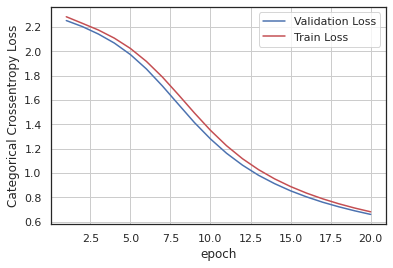

In [55]:
score = model_sigmoid.evaluate(X_val, Y_val, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

### MLP + Sigmoid activation + ADAM

In [57]:
model_sigmoid = Sequential()
model_sigmoid.add(Dense(512, activation='sigmoid', input_shape=(input_dim,)))
model_sigmoid.add(Dense(128, activation='sigmoid'))
model_sigmoid.add(Dense(output_dim, activation='softmax'))

model_sigmoid.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_35 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_36 (Dense)             (None, 10)                1290      
Total params: 468,874
Trainable params: 468,874
Non-trainable params: 0
_________________________________________________________________


In [58]:
model_sigmoid.compile(optimizer='adam', 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])

history = model_sigmoid.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_val, Y_val))

Train on 37800 samples, validate on 4200 samples
Epoch 1/20
37800/37800 [==============================] - 3s 92us/sample - loss: 0.6642 - acc: 0.8311 - val_loss: 0.3056 - val_acc: 0.9124
Epoch 2/20
37800/37800 [==============================] - 3s 88us/sample - loss: 0.2639 - acc: 0.9236 - val_loss: 0.2314 - val_acc: 0.9321
Epoch 3/20
37800/37800 [==============================] - 3s 89us/sample - loss: 0.2028 - acc: 0.9403 - val_loss: 0.1897 - val_acc: 0.9445
Epoch 4/20
37800/37800 [==============================] - 3s 87us/sample - loss: 0.1626 - acc: 0.9516 - val_loss: 0.1736 - val_acc: 0.9460
Epoch 5/20
37800/37800 [==============================] - 3s 87us/sample - loss: 0.1352 - acc: 0.9603 - val_loss: 0.1484 - val_acc: 0.9538
Epoch 6/20
37800/37800 [==============================] - 3s 85us/sample - loss: 0.1127 - acc: 0.9666 - val_loss: 0.1316 - val_acc: 0.9602
Epoch 7/20
37800/37800 [==============================] - 3s 88us/sample - loss: 0.0943 - acc: 0.9722 - val_loss: 0.1

Test score: 0.08016871640990887
Test accuracy: 0.97952384


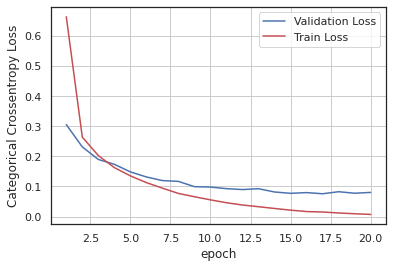

In [59]:
score = model_sigmoid.evaluate(X_val, Y_val, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))


vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

### MLP + ReLU +SGD

In [60]:
model_relu = Sequential()
model_relu.add(Dense(512, activation='relu', input_shape=(input_dim,), kernel_initializer=RandomNormal(mean=0.0, stddev=0.062, seed=None)))
model_relu.add(Dense(128, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.125, seed=None)) )
model_relu.add(Dense(output_dim, activation='softmax'))

model_relu.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_38 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_39 (Dense)             (None, 10)                1290      
Total params: 468,874
Trainable params: 468,874
Non-trainable params: 0
_________________________________________________________________


In [61]:
model_relu.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_relu.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_val, Y_val))

Train on 37800 samples, validate on 4200 samples
Epoch 1/20
37800/37800 [==============================] - 3s 89us/sample - loss: 0.9298 - acc: 0.7391 - val_loss: 0.4937 - val_acc: 0.8643
Epoch 2/20
37800/37800 [==============================] - 3s 81us/sample - loss: 0.4226 - acc: 0.8820 - val_loss: 0.3639 - val_acc: 0.8938
Epoch 3/20
37800/37800 [==============================] - 3s 81us/sample - loss: 0.3382 - acc: 0.9045 - val_loss: 0.3155 - val_acc: 0.9071
Epoch 4/20
37800/37800 [==============================] - 3s 82us/sample - loss: 0.2958 - acc: 0.9163 - val_loss: 0.2842 - val_acc: 0.9169
Epoch 5/20
37800/37800 [==============================] - 3s 81us/sample - loss: 0.2678 - acc: 0.9233 - val_loss: 0.2642 - val_acc: 0.9240
Epoch 6/20
37800/37800 [==============================] - 3s 83us/sample - loss: 0.2465 - acc: 0.9298 - val_loss: 0.2443 - val_acc: 0.9298
Epoch 7/20
37800/37800 [==============================] - 3s 82us/sample - loss: 0.2298 - acc: 0.9347 - val_loss: 0.2

Test score: 0.15836065705333438
Test accuracy: 0.95309526


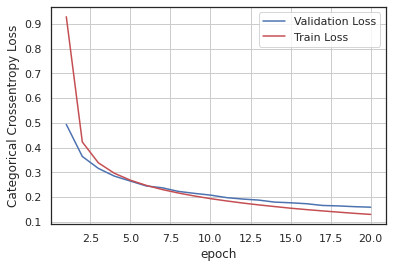

In [62]:
score = model_relu.evaluate(X_val, Y_val, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

### MLP + ReLU + ADAM

In [67]:
model_relu = Sequential()
model_relu.add(Dense(512, activation='relu', input_shape=(input_dim,), kernel_initializer=RandomNormal(mean=0.0, stddev=0.062, seed=None)))
model_relu.add(Dense(128, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.125, seed=None)) )
model_relu.add(Dense(output_dim, activation='softmax'))

model_relu.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_47 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_48 (Dense)             (None, 10)                1290      
Total params: 468,874
Trainable params: 468,874
Non-trainable params: 0
_________________________________________________________________


In [68]:
model_relu.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_relu.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_val, Y_val))

Train on 37800 samples, validate on 4200 samples
Epoch 1/20
37800/37800 [==============================] - 4s 95us/sample - loss: 0.2749 - acc: 0.9194 - val_loss: 0.1397 - val_acc: 0.9574
Epoch 2/20
37800/37800 [==============================] - 3s 87us/sample - loss: 0.1052 - acc: 0.9683 - val_loss: 0.1079 - val_acc: 0.9683
Epoch 3/20
37800/37800 [==============================] - 3s 89us/sample - loss: 0.0618 - acc: 0.9817 - val_loss: 0.0866 - val_acc: 0.9757
Epoch 4/20
37800/37800 [==============================] - 3s 89us/sample - loss: 0.0396 - acc: 0.9882 - val_loss: 0.0964 - val_acc: 0.9719
Epoch 5/20
37800/37800 [==============================] - 3s 89us/sample - loss: 0.0287 - acc: 0.9914 - val_loss: 0.0867 - val_acc: 0.9743
Epoch 6/20
37800/37800 [==============================] - 3s 88us/sample - loss: 0.0183 - acc: 0.9949 - val_loss: 0.0902 - val_acc: 0.9771
Epoch 7/20
37800/37800 [==============================] - 3s 89us/sample - loss: 0.0141 - acc: 0.9958 - val_loss: 0.0

Test score: 0.10298263925199405
Test accuracy: 0.9797619


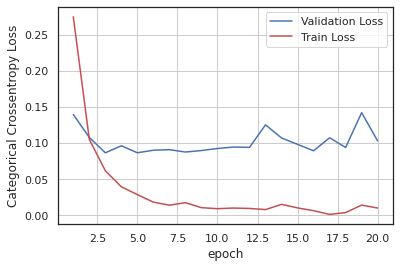

In [69]:
score = model_relu.evaluate(X_val, Y_val, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

### MLP with Batch-Normalization on hidden Layers + ADAM

In [70]:
model_batch = Sequential()

model_batch.add(Dense(512, activation='sigmoid', input_shape=(input_dim,), kernel_initializer=RandomNormal(mean=0.0, stddev=0.039, seed=None)))
model_batch.add(BatchNormalization())

model_batch.add(Dense(128, activation='sigmoid', kernel_initializer=RandomNormal(mean=0.0, stddev=0.55, seed=None)) )
model_batch.add(BatchNormalization())

model_batch.add(Dense(output_dim, activation='softmax'))


model_batch.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 512)               401920    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_50 (Dense)             (None, 128)               65664     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
dense_51 (Dense)             (None, 10)                1290      
Total params: 471,434
Trainable params: 470,154
Non-trainable params: 1,280
_________________________________________________________________


In [71]:
model_batch.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_batch.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_val, Y_val))

Train on 37800 samples, validate on 4200 samples
Epoch 1/20
37800/37800 [==============================] - 4s 113us/sample - loss: 0.3446 - acc: 0.8966 - val_loss: 0.2705 - val_acc: 0.9212
Epoch 2/20
37800/37800 [==============================] - 4s 99us/sample - loss: 0.1893 - acc: 0.9441 - val_loss: 0.2150 - val_acc: 0.9324
Epoch 3/20
37800/37800 [==============================] - 4s 99us/sample - loss: 0.1534 - acc: 0.9549 - val_loss: 0.1750 - val_acc: 0.9481
Epoch 4/20
37800/37800 [==============================] - 4s 100us/sample - loss: 0.1242 - acc: 0.9646 - val_loss: 0.1681 - val_acc: 0.9502
Epoch 5/20
37800/37800 [==============================] - 4s 98us/sample - loss: 0.1042 - acc: 0.9700 - val_loss: 0.1512 - val_acc: 0.9581
Epoch 6/20
37800/37800 [==============================] - 4s 101us/sample - loss: 0.0890 - acc: 0.9729 - val_loss: 0.1602 - val_acc: 0.9533
Epoch 7/20
37800/37800 [==============================] - 4s 102us/sample - loss: 0.0748 - acc: 0.9769 - val_loss:

Test score: 0.1356380645731198
Test accuracy: 0.96738094


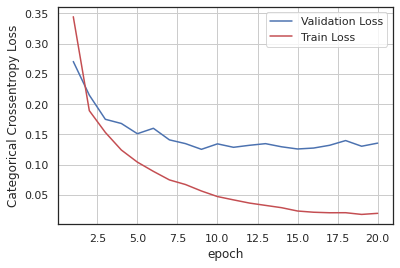

In [72]:
score = model_batch.evaluate(X_val, Y_val, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

### MLP + Dropout + ADAM

In [73]:
model_drop = Sequential()

model_drop.add(Dense(512, activation='sigmoid', input_shape=(input_dim,), kernel_initializer=RandomNormal(mean=0.0, stddev=0.039, seed=None)))
model_drop.add(BatchNormalization())
model_drop.add(Dropout(0.5))

model_drop.add(Dense(128, activation='sigmoid', kernel_initializer=RandomNormal(mean=0.0, stddev=0.55, seed=None)) )
model_drop.add(BatchNormalization())
model_drop.add(Dropout(0.5))

model_drop.add(Dense(output_dim, activation='softmax'))


model_drop.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 512)               401920    
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 128)               65664     
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_54 (Dense)             (None, 10)              

In [74]:
model_drop.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_val, Y_val))

Train on 37800 samples, validate on 4200 samples
Epoch 1/20
37800/37800 [==============================] - 5s 127us/sample - loss: 0.7505 - acc: 0.7671 - val_loss: 0.3416 - val_acc: 0.8986
Epoch 2/20
37800/37800 [==============================] - 4s 113us/sample - loss: 0.4722 - acc: 0.8553 - val_loss: 0.2800 - val_acc: 0.9150
Epoch 3/20
37800/37800 [==============================] - 4s 115us/sample - loss: 0.4095 - acc: 0.8761 - val_loss: 0.2538 - val_acc: 0.9224
Epoch 4/20
37800/37800 [==============================] - 4s 112us/sample - loss: 0.3778 - acc: 0.8855 - val_loss: 0.2443 - val_acc: 0.9250
Epoch 5/20
37800/37800 [==============================] - 4s 111us/sample - loss: 0.3623 - acc: 0.8908 - val_loss: 0.2375 - val_acc: 0.9274
Epoch 6/20
37800/37800 [==============================] - 4s 112us/sample - loss: 0.3454 - acc: 0.8948 - val_loss: 0.2294 - val_acc: 0.9305
Epoch 7/20
37800/37800 [==============================] - 4s 111us/sample - loss: 0.3339 - acc: 0.9007 - val_lo

Test score: 0.15763871030083723
Test accuracy: 0.95285714


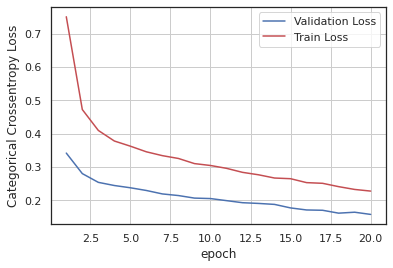

In [75]:
score = model_drop.evaluate(X_val, Y_val, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))


vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

## Hyper-parameter tuning for final model

In [76]:
def best_hyperparameters(activ):

    model = Sequential()
    model.add(Dense(512, activation=activ, input_shape=(input_dim,), kernel_initializer=RandomNormal(mean=0.0, stddev=0.062, seed=None)))
    model.add(Dense(128, activation=activ, kernel_initializer=RandomNormal(mean=0.0, stddev=0.125, seed=None)) )
    model.add(Dense(output_dim, activation='softmax'))


    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    
    return model

In [77]:
activ = ['sigmoid','relu']

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

model = KerasClassifier(build_fn=best_hyperparameters, epochs=nb_epoch, batch_size=batch_size, verbose=0)
param_grid = dict(activ=activ)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs = -1)
grid_result = grid.fit(X_train, Y_train)

In [78]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.976667 using {'activ': 'relu'}
0.973651 (0.001730) with: {'activ': 'sigmoid'}
0.976667 (0.002052) with: {'activ': 'relu'}


# Results

In [97]:
test = test/255

predictions = model_sigmoid.predict(test)
result = pd.DataFrame({
    'ImageId' : range(1,len(predictions)+1), 
})
result.to_csv('result.csv', index = False, encoding = 'utf-8')

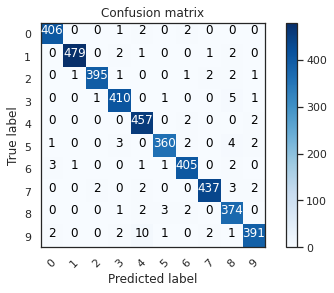

In [96]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model_sigmoid.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 